In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn import covariance

%matplotlib widget


In [2]:
# Helper functions
def get_balanced_df_by_category(df,category,subsample=None,replacement=True):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]

    num_to_sample = min(subsample if subsample is not None else num_per_category.min(), num_per_category.min())
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member.sample(num_to_sample,replace=replacement))
        else:
            output.append(member.sample(num_to_sample,replace=replacement))
    output = pd.concat(output,ignore_index=True)
    
    return output
    
def calculate_condition_number(X,estimator=covariance.MinCovDet):
    C = estimator().fit(X)
    cov = pd.DataFrame(C.covariance_,index=X.columns,columns=X.columns)
    D,L = linalg.eig(cov)
    cond_number = D.max() / D.min()
    return cond_number,cov


# Rank co-correlates
def print_top_cocorrelates(cov,num2print=50):
    cov_no_diag = cov.values
    cov_no_diag[np.eye(len(cov)).astype(bool)] = np.nan
    cov_no_diag[np.triu(np.ones(len(cov))).astype(bool)] = np.nan
    cov_no_diag = pd.DataFrame(cov_no_diag,index=cov.index,columns=cov.columns)
    return cov_no_diag.stack().dropna().abs().sort_values().tail(num2print)
    

In [3]:
# Grouped Standard Scaler
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    """
    Standardize features by removing the mean and scaling to unit variance,
    computed separately for each group defined by a categorical variable.
    
    Parameters
    ----------
    group_col : str
        Name of the categorical column to group by for standardization
    
    with_mean : bool, default=True
        If True, center the data before scaling
    
    with_std : bool, default=True
        If True, scale the data to unit variance
    
    Attributes
    ----------
    group_means_ : dict
        Dictionary mapping group values to mean arrays
    
    group_stds_ : dict
        Dictionary mapping group values to standard deviation arrays
    
    feature_names_ : list
        List of feature column names (excluding group_col)
    
    groups_ : array
        Unique group values seen during fit
    """
    
    def __init__(self, group_col, with_mean=True, with_std=True):
        self.group_col = group_col
        self.with_mean = with_mean
        self.with_std = with_std
    
    def fit(self, X, y=None):
        """
        Compute the mean and std to be used for later scaling, per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data used to compute the per-group means and standard deviations
            used for later scaling along the features axis.
        
        y : None
            Ignored
        
        Returns
        -------
        self : object
            Fitted scaler
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Store feature names (excluding group column)
        self.feature_names_ = [col for col in X.columns if col != self.group_col]
        
        # Use groupby for vectorized computation
        grouped = X.groupby(self.group_col)[self.feature_names_]
        
        if self.with_mean:
            self.group_means_ = grouped.mean()
        else:
            self.group_means_ = pd.DataFrame(
                0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        if self.with_std:
            self.group_stds_ = grouped.std()
            # Replace zero std with 1 to avoid division by zero
            self.group_stds_ = self.group_stds_.replace(0, 1.0)
        else:
            self.group_stds_ = pd.DataFrame(
                1.0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        return self
    
    def transform(self, X):
        """
        Perform standardization by centering and scaling per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to transform
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy to avoid modifying original
        X_transformed = X.copy()
        
        # Align means and stds with X using merge (much faster than map)
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized standardization
        X_transformed[self.feature_names_] = (
            X[self.feature_names_].values - means_aligned[self.feature_names_].values
        ) / stds_aligned[self.feature_names_].values
        
        # Check for unseen groups (NaN values after join)
        if means_aligned[self.feature_names_].isna().any().any():
            unseen_groups = X.loc[means_aligned[self.feature_names_].isna().any(axis=1), self.group_col].unique()
            import warnings
            warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
            # Keep original values for unseen groups (where NaN resulted)
            nan_mask = means_aligned[self.feature_names_].isna().any(axis=1)
            X_transformed.loc[nan_mask, self.feature_names_] = X.loc[nan_mask, self.feature_names_]
        
        return X_transformed.drop(columns=self.group_col)
    
    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            Input data
        
        y : None
            Ignored
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Scale back the data to the original representation per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to inverse transform
        
        Returns
        -------
        X_original : pandas DataFrame of shape (n_samples, n_features)
            DataFrame in original scale
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy
        X_original = X.copy()
        
        # Align means and stds with X using merge
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized inverse transformation
        X_original[self.feature_names_] = (
            X[self.feature_names_].values * stds_aligned[self.feature_names_].values
        ) + means_aligned[self.feature_names_].values
        
        return X_original
        


In [4]:
# Load data
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/'

all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'duration' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Manual' in f]
features2drop += [(f,a) for f,a in divisions.columns if '2um' in f]
features2drop += [(f,a) for f,a in divisions.columns if '10um' in f]
features2drop += [(f,a) for f,a in divisions.columns if '15um' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Total' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))

feature2predict = 'At least one daughter differentiated'
_df = divisions.dropna(subset=[(feature2predict,'Meta')])

y = _df[feature2predict,'Meta']
X = _df.xs('Measurement',level=1,axis=1)

important_features = X.columns
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# X['Region'] = [f[0] for f in X.index.get_level_values(1).str.split('_',expand=True)]
# X_scaled = GroupedStandardScaler('Region').fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns= important_features)
print(X_scaled.shape)

668
(303, 839)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_81700/4014000220.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


# 1. Pre-selection method: RF trees

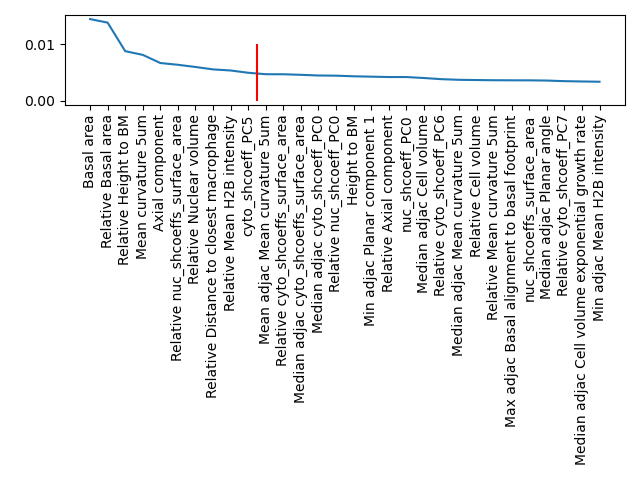

In [8]:
# Take top 50 features by importance and see their correlation matrix
importances = pd.read_csv(path.join(model_dir,'Random_forest_division/importances.csv'),
                         index_col=0)
importances = importances.rename(columns={'0':'RF_imp'})

num_to_take = 10

important_features = importances.sort_values(by='RF_imp').tail(num_to_take).index

plt.close('all')
fig = plt.figure()
plt.plot(importances.sort_values(by='RF_imp')['RF_imp'][::-1][:30] )
plt.vlines(x=num_to_take-0.5,ymin=0,ymax=0.01,color='r')
plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig(path.join(model_dir,'Random_forest_division/importance_cutoff.svg'))

features2keep = important_features

ValueError: Input X contains NaN.
MinCovDet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

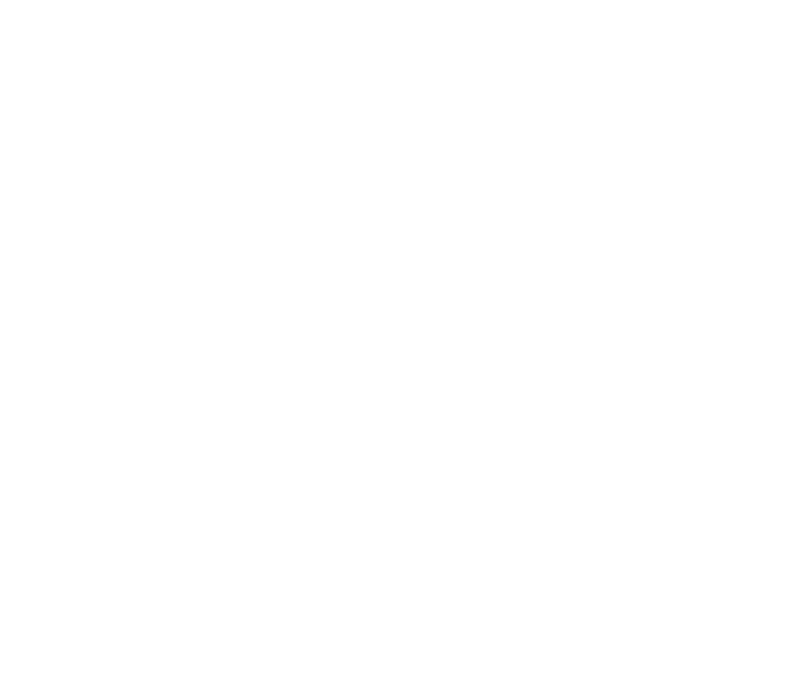

In [190]:
# Calculate the condition number
from numpy import linalg

plt.figure(figsize=(8,7))
cond_num, cov = calculate_condition_number(X_scaled)
sb.heatmap(cov)
plt.tight_layout()
print(cov.shape)

D,L = linalg.eig(cov)
print(f'Condition number: {cond_num}')

# print_top_cocorrelates(cov)

# 1. Single feature selector

In [149]:
# Single feature Logistic

features = X_scaled.columns

results = pd.DataFrame(index=features,columns=['Coef','Pval','-LogP'])

for f in features:
    X = _df.droplevel(axis=1,level=1)[f].astype(float)
    if np.isnan(X).any():
        continue
    model = Logit(endog=y_,exog=_df.droplevel(axis=1,level=1)[f].astype(float)).fit_regularized()
    
    results.loc[f,'Coef'] = model.params.values
    results.loc[f,'Pval'] = model.pvalues.values
    results.loc[f,'-LogP'] = -np.log10(model.pvalues.values)

results['Abs coef'] = results['Coef'].abs()
results.sort_values(by='Coef')

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/di

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5651849060785634
            Iterations: 7
            Function evaluations: 12
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5485705290138231
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5931150372356201
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5610246779709124
            Iterations: 7
            Function evaluations: 11
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5428054746762039
            Iterations: 7
            Function evaluations: 

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/di

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6929545359575233
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6925752452528295
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.689291247735636
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6927586489619019
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6926205025250444
            Iterations: 6
            Function evaluations: 6
  

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/di

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.693070023460645
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6924257755275659
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6930964463750015
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6906796229403447
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6923520221758916
            Iterations: 6
            Function evaluations: 6
  

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/di

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5436303040508704
            Iterations: 7
            Function evaluations: 12
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5456003755306195
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5438597201158133
            Iterations: 7
            Function evaluations: 9
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5477132749903056
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5506235587063967
            Iterations: 6
            Function evaluations: 7

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/di

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5498162168749315
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5765123951782353
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5692275907546498
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5570071167538927
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5847645898770377
            Iterations: 6
            Function evaluations: 8


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5443504877289057
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5715438986216241
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5498636427647215
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5494510926390128
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5672786421166017
            Iterations: 6
            Function evaluations: 6
 

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


,Coef,Pval,-LogP,Abs coef
Name,,,,
Min adjac Gaussian curvature 5um,-33.68438318540506,3.2039051735281394e-12,11.494320346277846,33.684383
Mean adjac Mean curvature 5um,-6.134555285058686,1.9317613898193183e-09,8.71404651844046,6.134555
Median adjac Mean curvature 5um,-4.789098525175272,8.487340152777353e-08,7.071228391965693,4.789099
Min adjac Mean curvature 5um,-2.7818131175452945,2.217935285822502e-15,14.654051129701829,2.781813
Mean curvature 5um,-2.288940882341373,3.4765034327955078e-06,5.458857337443788,2.288941
...,...,...,...,...
Diff from Mean adjac Collagen coherence at 1 frame prior,NaN,NaN,NaN,NaN
Diff from Min adjac Planar component 1 at 1 frame prior,NaN,NaN,NaN,NaN
Diff from Mean adjac nuc_shcoeff_PC3 at 1 frame prior,NaN,NaN,NaN,NaN


In [150]:
results.dropna().sort_values(by='-LogP',ascending=False).head(260)
features2keep = results.dropna().sort_values(by='-LogP',ascending=False).head(260).index

# Condition number of remaining features

In [18]:
# Eliminate covarying features

# features2keep = important_features.drop(['Relative Total H2B intensity',
#                                          'Basal area',
                                         # 'Relative Nuclear volume',
                                        # ])
# features2keep = ['Relative Basal area','Mean curvature 5um','Relative Nuclear volume',
#                 'Std adjac nuc_shcoeffs_L2M0C']
features2keep = important_features
# features2keep = features

cond_num, cov_ = calculate_condition_number(X_scaled[pd.Index(features2keep)])
print(cond_num)
X_ = X_scaled[features2keep]
plt.close('all')
plt.figure()
sb.heatmap(cov_)
plt.tight_layout()

print_top_cocorrelates(cov_,num2print=20)
# cov_

ValueError: Input X contains NaN.
MinCovDet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# ElastiNet

In [9]:
# Data prep
from statsmodels.api import Logit, GLM, families
from sklearn import model_selection, metrics
from statsmodels.tools import tools

X_ = X_scaled[features2keep].astype(float)
X_ = pd.DataFrame(tools.add_constant(X_))
y_ = np.asarray(y).astype(bool)

data_ = X_
data_['endog'] = ~y_


In [ ]:
# Test small set of model regularization - crossvalidation accuracy
# CV_accuracy = pd.DataFrame()
Niter = 50
alphas = 10.**np.arange(-5,-1)
L1Ws = [1,0.8,0.5,0.2,0.1,0.01,0]

index = pd.MultiIndex.from_product([range(Niter),alphas,L1Ws],names=['iter','alpha','L1'])
CV_accuracy = pd.DataFrame(index=index,columns=['Score'])
CV_AUC = pd.DataFrame(index=index,columns=['Score'])
# CV_params = pd.DataFrame(columns=list(features2keep)+['constant'],index=range(Niter))

for a in tqdm(alphas):
    for l1w in L1Ws:
        for i in range(Niter):
            X_train,X_test,y_train,y_test = model_selection.train_test_split(data_.drop(columns='endog').values,data_['endog'].values)
            model = GLM(endog = y_train,exog= X_train,
                            family=families.Binomial()).fit_regularized(alpha = 0.1,L1_wt=0.01) # L2-biased to reduce collinearity
            y_pred = model.predict(X_test) > 0.5
            CV_accuracy.loc[(i,a,l1w),'Score'] = metrics.accuracy_score(y_test,y_pred)
            CV_AUC.loc[(i,a,l1w),'Score'] = metrics.roc_auc_score(y_test,y_pred)
            # CV_params.loc[(i,a,l1w)] = model.params

CV_accuracy.reset_index()
plt.close('all')
plt.figure()
plt.subplot(1,2,1)
sb.lineplot(CV_accuracy.reset_index(),x='alpha',y='Score',hue='L1',estimator='mean',errorbar='se')
plt.subplot(1,2,2)
sb.lineplot(CV_AUC,x='alpha',y='Score',hue='L1')


In [11]:
# ElastiNet GLM regularized
from statsmodels.api import Logit, GLM, families
from statsmodels.base.elastic_net import RegularizedResults
from scipy import stats

Niter = 1000

alpha = 0.01
l1w = 0.1

CV_params = pd.DataFrame(columns=list(features2keep)+['constant'],index=range(Niter))
CV_results = pd.DataFrame()
CV_confusion = np.zeros((Niter,2,2))
for i in tqdm(range(Niter)):
    
    data_balanced = get_balanced_df_by_category(data_,category='endog')
    X_train,X_test,y_train,y_test = model_selection.train_test_split(
        data_balanced.drop(columns='endog').values,data_balanced['endog'].values)
    
    model = GLM(endog = y_train, exog = X_train,
                family=families.Binomial()).fit_regularized(alpha = alpha,L1_wt=l1w)
    CV_params.loc[i] = model.params
    y_pred = model.predict(X_test) > 0.5
    CV_results.loc[i,'Accuracy'] = metrics.accuracy_score(y_test,y_pred)
    CV_results.loc[i,'AUC'] = metrics.roc_auc_score(y_test,y_pred)
    CV_confusion[i,:,:] = metrics.confusion_matrix(y_test,y_pred)


avg_results = pd.DataFrame({'mean':CV_params.mean(),
                            'std':CV_params.std(),
                            'effect_magnitude':CV_params.mean().abs(),
                           'snr':CV_params.mean().abs()/CV_params.std(),
                           'pval':(CV_params == 0).sum(axis=0)/Niter})

avg_results.sort_values(by='snr')
avg_results['-LogP'] = -np.log10(avg_results['pval'])

avg_results.sort_values(by='effect_magnitude')

{col:stats.ttest_1samp(CV_params[col].astype(float), popmean=0) for col in CV_params.columns}


  0%|                                                                                              | 0/1000 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
  0%|▏                                                                                     | 2/1000 [00:00<01:15, 13.16it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model

{'cyto_shcoeff_PC5': TtestResult(statistic=np.float64(-59.14485262083812), pvalue=np.float64(0.0), df=np.int64(999)),
 'Relative Mean H2B intensity': TtestResult(statistic=np.float64(47.318652427439595), pvalue=np.float64(2.3876285596146608e-257), df=np.int64(999)),
 'Relative Distance to closest macrophage': TtestResult(statistic=np.float64(19.750235156685576), pvalue=np.float64(1.4747306814532856e-73), df=np.int64(999)),
 'Relative Nuclear volume': TtestResult(statistic=np.float64(1.3345412952026758), pvalue=np.float64(0.18233060869360734), df=np.int64(999)),
 'Relative nuc_shcoeffs_surface_area': TtestResult(statistic=np.float64(6.7341702418661), pvalue=np.float64(2.7774838992442445e-11), df=np.int64(999)),
 'Axial component': TtestResult(statistic=np.float64(41.523786952556904), pvalue=np.float64(9.11574559052703e-220), df=np.int64(999)),
 'Mean curvature 5um': TtestResult(statistic=np.float64(31.426357426004785), pvalue=np.float64(2.6818476238580285e-151), df=np.int64(999)),
 'Rel

0.7101388888888889


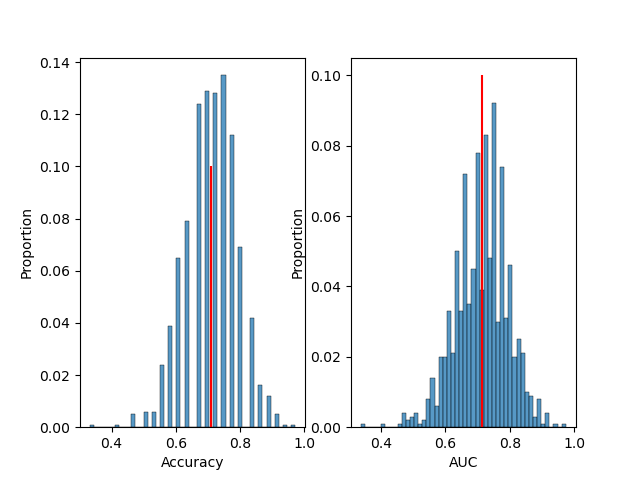

In [15]:
print(CV_results['Accuracy'].mean())
plt.close('all')
fig = plt.figure()
plt.subplot(1,2,1)
sb.histplot(CV_results['Accuracy'],bins=50,stat='proportion')
plt.vlines(x=CV_results['Accuracy'].mean(),ymin=0,ymax=0.1,color='red')
plt.subplot(1,2,2)
sb.histplot(CV_results['AUC'],bins=50,stat='proportion')
plt.vlines(x=CV_results['AUC'].mean(),ymin=0,ymax=0.1,color='red')
fig.savefig(path.join(model_dir,'Linear_model_division/GLM_CV_accuracy.svg'))

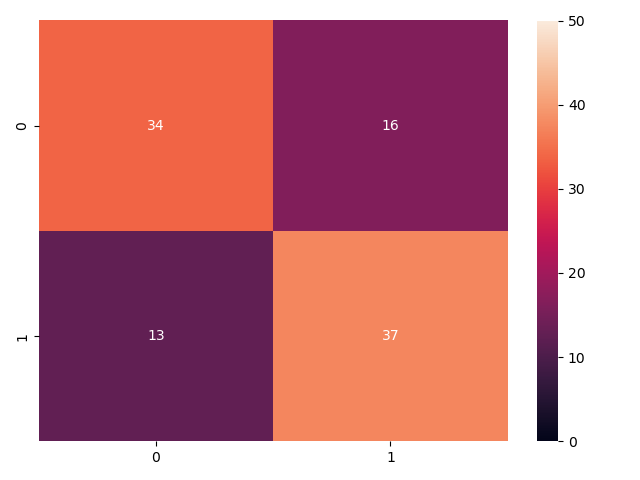

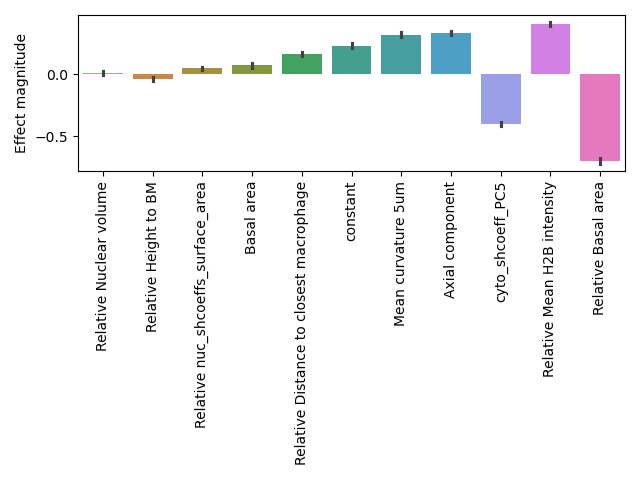

In [16]:
plt.close('all')

fig = plt.figure()
sb.heatmap(CV_confusion.mean(axis=0)/len(y_test)*100,annot=True,vmin=0,vmax=50)
plt.tight_layout()
fig.savefig(path.join(model_dir,'Linear_model_division/GLM_CV_confusion.svg'))

fig = plt.figure()
sb.barplot(CV_params[CV_params.columns[avg_results['effect_magnitude'].argsort()]])
plt.ylabel('Effect magnitude')
plt.xticks(rotation=90)
plt.tight_layout()

fig.savefig(path.join(model_dir,'Linear_model_division/GLM_CV_coefficients.svg'))


# PCA

In [274]:
model_dir

'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/'

Accuracy: 83%


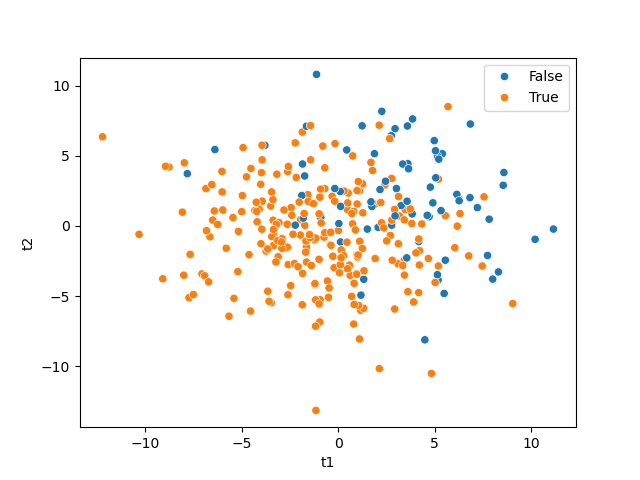

In [437]:
from sklearn import cross_decomposition
pls = cross_decomposition.PLSRegression()
pls.fit(X_scaled.values,y_)

X_transformed = pd.DataFrame(pls.x_scores_,columns=[f't{i+1}' for i in range(2)],
                            index=X.index)
X_transformed
plt.figure()
ax = sb.scatterplot(x=X_transformed['t1'],y=X_transformed['t2'],hue=y_)

pd.Series(pls.coef_[0,:],index=X_scaled.columns)
accuracy = metrics.accuracy_score(y_,pls.predict(X_scaled.values) > 0.5)
print(f'Accuracy: {accuracy * 100:.0f}%')

In [448]:
X_loadings = pd.Series(pls.coef_[0,:],index=X_scaled.columns)
X_loadings.abs().sort_values().tail(10)

Name
nuc_shcoeff_PC0                       0.010056
Median adjac Mean curvature 15um      0.010162
Relative nuc_shcoeffs_surface_area    0.010520
Max adjac Mean curvature 15um         0.010526
cyto_shcoeff_PC5                      0.010630
Median adjac Mean curvature 10um      0.010684
Relative Mean H2B intensity           0.011507
Relative Total H2B intensity          0.012306
Basal area                            0.013635
Relative Basal area                   0.014293
dtype: float64

In [450]:
_df.droplevel(axis=1,level=1).sort_values(by='cyto_shcoeff_PC5').tail(10)

Name           Nuclear volume  Nuclear solidity          Y          X  \
Frame TrackID                                                           
1     R2_614         183.4375          0.816639  53.110221  15.699148   
0     R2_467         236.9375          0.814918  87.626550  19.929306   
7     R1_977         308.3125          0.906801  98.889520  57.276353   
0     R2_417         255.6875          0.842984  53.702762  22.986311   
4     R2_928         198.7500          0.889510  83.901336  83.853302   
2     R2_493         316.8750          0.869938  97.586686  57.485454   
0     R2_754         244.5000          0.869720  44.744312  62.720412   
4     R1_1036        271.6875          0.935845  53.986772  76.344548   
      R2_577         232.2500          0.863383  46.105826  25.960441   
6     R2_891         207.1875          0.899349  89.143363  98.394721   

Name           Nuclear height  Cell volume     Y-cyto     X-cyto  \
Frame TrackID                                                      
1     R2_614             -9.0     584.4375  53.161560  15.964629   
0     R2_467            -11.0     615.1250  87.509805  19.638641   
7     R1_977            -15.0     685.5625  98.592989  57.201431   
0     R2_417            -12.0     717.4375  53.778683  23.107566   
4     R2_928            -10.0     539.0000  83.803137  83.934949   
2     R2_493            -12.0     634.1875  97.263674  57.448458   
0     R2_754            -10.0     625.6250  44.974750  62.583017   
4     R1_1036           -11.0     681.0625  54.327636  76.456731   
      R2_577            -11.0     660.4375  46.074075  25.748841   
6     R2_891             -9.0     628.9375  89.205654  98.740535   

Name           Axial component  Planar component 1  ...  \
Frame TrackID                                       ...   
1     R2_614         17.113087            8.219607  ...   
0     R2_467          8.551352           22.691235  ...   
7     R1_977          6.893717           26.637240  ...   
0     R2_417          8.796992           21.077037  ...   
4     R2_928          8.680936           17.537834  ...   
2     R2_493          9.486334           17.002592  ...   
0     R2_754          9.531980           15.675935  ...   
4     R1_1036         9.346459           17.316046  ...   
      R2_577          8.319667           20.321350  ...   
6     R2_891          9.355092           17.731490  ...   

Name           Diff from Min adjac cyto_shcoeff_PC7 at 1 frame prior  \
Frame TrackID                                                          
1     R2_614                                           -0.711779       
0     R2_467                                                 NaN       
7     R1_977                                            0.961209       
0     R2_417                                                 NaN       
4     R2_928                                            0.147186       
2     R2_493                                           -0.471597       
0     R2_754                                                 NaN       
4     R1_1036                                          -1.100429       
      R2_577                                            0.025920       
6     R2_891                                            0.170110       

Name           Diff from Mean adjac Collagen coherence at 1 frame prior  \
Frame TrackID                                                             
1     R2_614                                           -0.092867          
0     R2_467                                                 NaN          
7     R1_977                                           -0.187392          
0     R2_417                                                 NaN          
4     R2_928                                           -0.057477          
2     R2_493                                            0.008630          
0     R2_754                                                 NaN          
4     R1_1036                                          -0

In [451]:
_df.droplevel(axis=1,level=1).sort_values(by='cyto_shcoeff_PC5').head(10)

Name           Nuclear volume  Nuclear solidity          Y          X  \
Frame TrackID                                                           
3     R2_208         159.8750          0.533139  24.030102  28.324081   
      R1_1083        210.9375          0.855730  70.511704  98.287704   
7     R2_6           254.3750          0.702693  20.955098  95.258477   
3     R2_85          250.9375          0.858273  57.962204  79.332379   
0     R1_1074        203.5000          0.826396  97.397343  69.768811   
6     R2_21          273.5625          0.917610  67.728239  59.270619   
8     R1_686         292.7500          0.922774  23.320880  68.941877   
1     R1_24          249.5000          0.890674   7.703219  79.354897   
2     R2_12          199.7500          0.851359  15.048576  10.479662   
6     R1_989         331.3125          0.715385  46.132664  12.816261   

Name           Nuclear height  Cell volume     Y-cyto     X-cyto  \
Frame TrackID                                                      
3     R2_208            -10.0     749.8125  23.946007  28.399183   
      R1_1083           -13.0     546.8125  70.784547  98.579552   
7     R2_6              -11.0     853.0000  21.242032  95.518538   
3     R2_85             -10.0     608.5625  57.674309  79.188123   
0     R1_1074           -12.0     716.7500  97.991215  69.883328   
6     R2_21             -10.0     721.5000  68.030665  59.878097   
8     R1_686            -11.0     590.1250  23.441511  69.047130   
1     R1_24             -11.0     740.3750   7.283999  79.093935   
2     R2_12             -10.0     647.7500  15.193000  10.236926   
6     R1_989            -11.0     710.5000  45.987883  13.101535   

Name           Axial component  Planar component 1  ...  \
Frame TrackID                                       ...   
3     R2_208         10.486834           17.262470  ...   
      R1_1083         7.352584           17.548808  ...   
7     R2_6           12.350902           16.249520  ...   
3     R2_85           8.003747           16.253811  ...   
0     R1_1074         8.173750           22.066080  ...   
6     R2_21           9.631969           16.978085  ...   
8     R1_686          9.846128           15.450702  ...   
1     R1_24          11.811411           20.800684  ...   
2     R2_12           8.654770           20.753989  ...   
6     R1_989         12.477260           12.038947  ...   

Name           Diff from Min adjac cyto_shcoeff_PC7 at 1 frame prior  \
Frame TrackID                                                          
3     R2_208                                           -0.234667       
      R1_1083                                           0.000325       
7     R2_6                                             -0.526080       
3     R2_85                                            -0.437424       
0     R1_1074                                                NaN       
6     R2_21                                            -0.139574       
8     R1_686                                           -1.014982       
1     R1_24                                             0.514406       
2     R2_12                                            -0.449455       
6     R1_989                                           -0.201387       

Name           Diff from Mean adjac Collagen coherence at 1 frame prior  \
Frame TrackID                                                             
3     R2_208                                            0.206083          
      R1_1083                                           0.095967          
7     R2_6                                             -0.129869          
3     R2_85                                            -0.171868          
0     R1_1074                                                NaN          
6     R2_21                                            -0.177656          
8     R1_686                                            0.004094          
1     R1_24                                            -0

<Axes: xlabel='Relative Basal area', ylabel='cyto_shcoeff_PC5'>

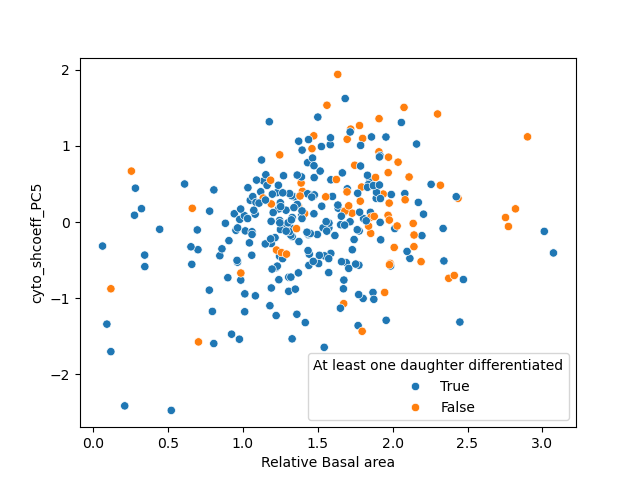

In [156]:
plt.figure()
sb.scatterplot(divisions.droplevel(axis=1,level=1),x='Relative Basal area',y='cyto_shcoeff_PC5',hue=feature2predict)